In [1]:
!mkdir /root/.kaggle

In [2]:
!cp ./kaggle.json /root/.kaggle/

In [3]:
! ls /root/.kaggle

kaggle.json


In [4]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 78.0MB/s]
 98% 532M/543M [00:02<00:00, 290MB/s]
100% 543M/543M [00:02<00:00, 208MB/s]
 96% 261M/271M [00:03<00:00, 76.5MB/s]
100% 271M/271M [00:03<00:00, 81.1MB/s]


In [ ]:
!unzip /content/train.zip

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time


<img src="./../img/vgg.png" height = 720>

today, what we will implement is D network (VGG16).

its all conv layers are conv3x3, with stride == 1, and padding == 1, which means this conv will not change the size of image. all downsampling are done by the maxpool (kernel_size == 2, stride == 2) to half the image size.

vgg is designed for large image, so the input image size should be (3, 224, 224)

In [2]:
seed = 7
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
         # (N, img_channel, 224, 224)
vgg16 = [64, 64, 'M',
         # (N. 64, 112, 112)
        128, 128, 'M',
         # (N, 128, 56, 56)
        256, 256, 256, 'M',
         # (N, 256, 28, 28)
        512, 512, 512, 'M',
         # (N, 512, 14, 14)
        512, 512, 512, 'M']
         # (N, 512, 7, 7)
         # after the Linear layer, the tensor will be map into
         # (N, num_class)

In [4]:
class Vgg(nn.Module):
    def __init__(self, layer_arch, img_channel, num_class) -> None:
        super(Vgg, self).__init__()
        self.arch = layer_arch
        self.img_channel = img_channel
        self.num_class = num_class

        # create conv layers: feature
        self.feature = self._creat_conv()
        # create linear layers: classifier
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_class)
        )

        
    def _conv_block(self, inchannel, outchannel, kernel_size, stride, padding):
        # classic conv, bn, relu
        return nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size, stride, padding),
            nn.BatchNorm2d(outchannel),
            nn.ReLU()
        )

    def _creat_conv(self):
        conv_net = []
        inchannel = self.img_channel
        for each in self.arch:
            if type(each) == int:
                outchannel = each
                conv_net.append(self._conv_block(inchannel, outchannel, (3,3), 1, 1))
                inchannel = outchannel
            if type(each) == str:
                conv_net.append(nn.MaxPool2d(kernel_size=(2,2), stride=2))
        return nn.Sequential(*conv_net)

    def forward(self, x):
        x = self.feature(x)
        x = x.reshape((x.shape[0],-1))
        return self.classifier(x)

In [5]:
class DogCatDataset(Dataset):
    def __init__(self, mode, transform, path='./train/'):
        self.mode = mode
        self.transform = transform
        self.path = path
        self.lst = os.listdir(self.path)

    def __len__(self):
        return len(self.lst)

    def __getitem__(self, idx):
        img = Image.open(self.path + self.lst[idx])
        if self.mode == "train":
            # dog == 0, cat == 1
            label = 1 if "cat" in self.lst[idx] else 0
            # do transform
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            if self.transform:
                img = self.transform(img)
            return img


In [6]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])
dataset = DogCatDataset("train", transform)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_channel = 3
num_class = 2
num_epoch = 3
l_r = 1e-3
batch_size = 32

In [8]:
ratio = 0.9
train_len = int(len(dataset) * ratio)
valid_len = len(dataset) - train_len
train_set, valid_set = torch.utils.data.random_split(dataset, [train_len, valid_len])
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_set, shuffle=False, batch_size=batch_size)

IndexError: ignored

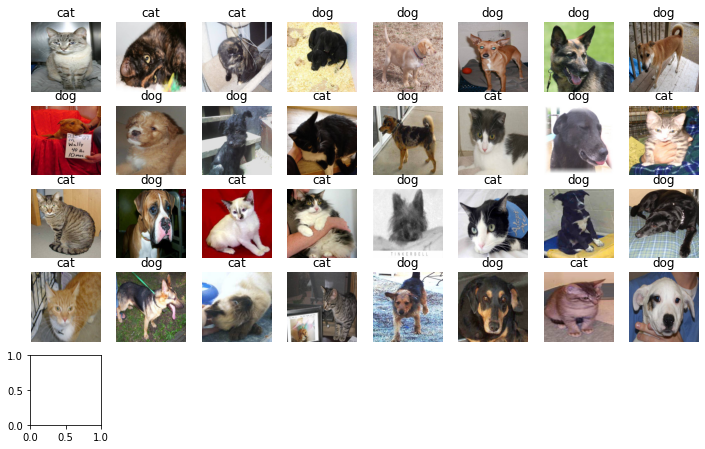

In [15]:
plt.figure(figsize=(12, 12))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i].squeeze().permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title("cat" if y[i]==1 else "dog")
plt.show()

In [16]:
x = x.to(device)
y = y.to(device)
iter_num = 100
# use a new model to do the overfit
model = Vgg(vgg16, 3, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=l_r)
criterion = nn.CrossEntropyLoss()

In [17]:
for iter in range(iter_num):
    pred = model(x)
    loss = criterion(pred, y)

    model.zero_grad()
    loss.backward()
    optimizer.step()
    if iter % 10 == 0:
      print(f"current loss:{loss:4f}")
out = model(x)
pred = torch.argmax(out, dim=1).squeeze()
filt = (pred == y)
acc = torch.sum(filt) / len(x)
print(f"current acc is {acc}")

current loss:0.695633
current loss:0.645690
current loss:0.603661
current loss:0.470808
current loss:0.052185
current loss:0.194633
current loss:0.031166
current loss:0.001453
current loss:0.000287
current loss:0.000062
current acc is 1.0


In [9]:
! rm -rf ./run
writer = SummaryWriter(log_dir="run/vgg")
lenet = Vgg(vgg16, img_channel, num_class).to(device)
optimizer = optim.Adam(lenet.parameters(), lr=l_r)
criterion = nn.CrossEntropyLoss()
state_dict = {
    "model": None,
    "optim": None
}

In [19]:
writer = SummaryWriter(log_dir="run/vgg4")

In [ ]:
batch_step = 0
valid_step = 0
max_acc = 0
for epoch in range(num_epoch):
    loop =  tqdm(train_dataloader, leave=True)
    for batch_idx, (x, y) in enumerate(loop):

        lenet.train()
        batch_step += 1

        x = x.to(device)
        y = y.to(device)
        
        pred = lenet(x)
        loss = criterion(pred, y)

        lenet.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar(tag="loss", scalar_value=loss, global_step=batch_step)
        # if epoch == 0 and batch_idx % 10 == 0:
        #   print(f"loss: {loss:4f}")


    # eval the model
    lenet.eval()
    acc = valid(lenet, valid_dataloader)
    if acc > max_acc:
        max_acc = acc
        state_dict["model"] = lenet.state_dict()
        state_dict["optim"] = optimizer.state_dict()
        save_checkpoint(state_dict)
    print(f"epoch:[{epoch:2d}/{num_epoch}]")
    print(f"current valid acc:{acc:4f}")
    writer.add_scalar(tag="acc", scalar_value=acc, global_step=valid_step)


 99%|█████████▉| 700/704 [07:23<00:02,  1.58it/s]

In [10]:

#%%
def save_checkpoint(data, path="model.pth.tar"):
    print("=> saving model !")
    now = time.strftime("%D_%H:%M")
    print(f"saving checkpoint at {now}, path is '{path}'")
    torch.save(data, path)
#%%
def valid(model, valid_dataloader):
    num_right = 0
    total_len = 0
    softmax = nn.Softmax()
    with torch.no_grad():
      loop = tqdm(valid_dataloader)
      for i, (x, y) in enumerate(loop):
        x = x.to(device)
        total_len += len(x)
        y = y.to(device)

        out = model(x)
        pred = torch.argmax(out, dim=1).squeeze()
        filt = (pred == y)
        num_right += torch.sum(filt)
    acc = num_right / total_len
    return acc